In [1]:
#Notebook taken and modified from https://nbviewer.org/url/arteagac.github.io/blog/lime_image.ipynb

import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
import os
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

2024-02-05 13:18:21.438095: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
folder = 'pickle'
inner_folder = 'augmented_model'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'rb') as f:
    model = pickle.load(f)

2024-02-05 13:18:23.844211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-05 13:18:23.855271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-05 13:18:23.855521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

In [3]:
with open(os.path.join(folder, inner_folder, 'confusion_data'), 'rb') as f:
    loaded_confusion_data = pickle.load(f)
    
class_names = loaded_confusion_data['class_labels']

In [4]:
img = skimage.io.imread("Data_Subset_Validation/PMO/PMO_00014.jpg")
yhat = model.predict(np.expand_dims(img/255, 0))
max_index = np.argmax(yhat)
print(class_names[max_index])

2024-02-05 13:18:24.924626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901


1/1 [==============================] - 1s 770ms/step
PMO


2024-02-05 13:18:25.340810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [5]:
superpixels = skimage.segmentation.quickshift(img, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

52

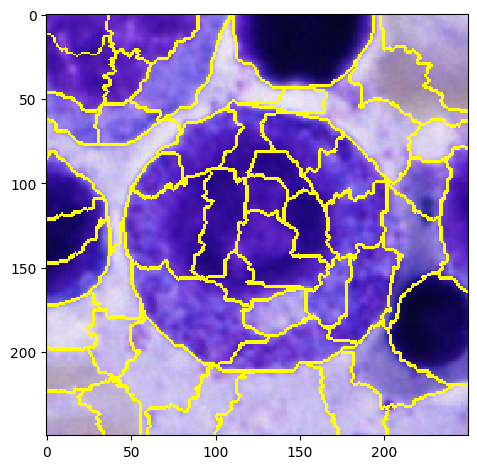

In [6]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(img, superpixels))

In [7]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1])

In [8]:
def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image * mask[:, :, np.newaxis]
    
    # Normalize to the range [0, 1]
    perturbed_image = perturbed_image / 255.0
    return perturbed_image

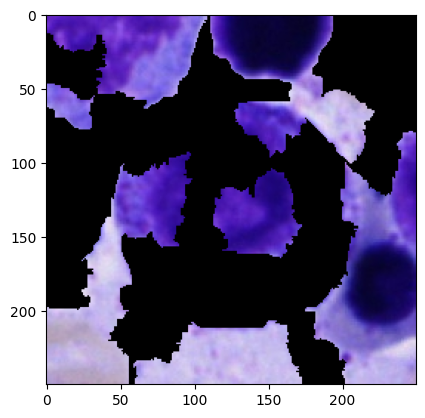

In [9]:
plt.imshow(perturb_image(img, perturbations[0], superpixels))
plt.show()

In [10]:
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(img,pert,superpixels)
    pred = model.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

1/1 [==============================] - 0s 16ms/step


(150, 1, 21)

In [11]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [12]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [13]:
class_to_explain = max_index
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([-0.01993017, -0.02456706, -0.01263162,  0.00572886, -0.00099907,
        0.01793554, -0.02079241,  0.00487026,  0.0061195 ,  0.00655497,
        0.01330882,  0.0075111 ,  0.01759208, -0.00631919, -0.00901783,
       -0.00306973, -0.02548118, -0.00884608,  0.01294519,  0.0282711 ,
       -0.01352434, -0.00921594, -0.00628843,  0.00321973,  0.00419005,
        0.00466456, -0.02201248,  0.01636867, -0.01906823, -0.02117361,
       -0.02769362, -0.00860003,  0.01712835,  0.00217424,  0.00938211,
        0.00092055, -0.00103669,  0.0083834 , -0.0277544 , -0.02284482,
        0.01036461,  0.00766618,  0.00551794, -0.01103302, -0.00392135,
        0.01453279, -0.01155658,  0.00371677, -0.00810748, -0.01236902,
       -0.01151643, -0.01013489])

In [24]:
num_top_features = 6
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([45, 27, 32, 12,  5, 19])

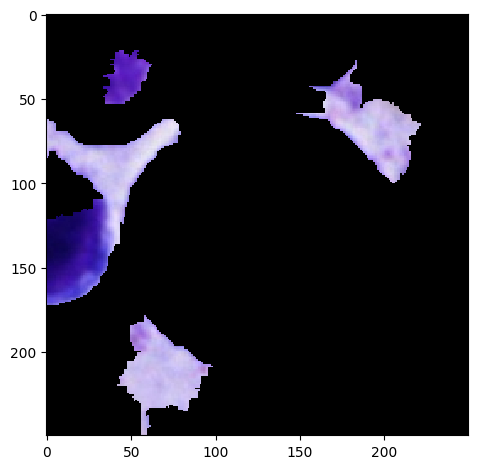

In [25]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(img,mask,superpixels) )